In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import gcm
from sklearn.linear_model import RidgeCV

# Set colours for plots
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# <ins>Introduction</ins>

This notebook gives a practical introduction to the potential of causal graphs.

**It is aimed at anyone who wants to understand more about:**
- What causal graphs are and how they work.
- A worked case study in Python illustrating how to build causal graphs.
- How they compare to ML.
- The key challenges and future considerations.

# <ins>What are causal graphs?</ins>

Causal graphs help us disentangle causes from correlations. They are a key part of the causal inference/causal ML/causal AI toolbox and can be used to answer causal questions.

<img src="../images/causal_graph.png" alt="Drawing" style="width: 500px;"/>

Often referred to as a DAG (directed acyclic graph), a causal graph contains nodes and edges - Edges link nodes that causally related. 

There are two ways to determine a causal graph:
- Expert domain knowledge
- Causal discovery algorithms

For now, we will assume we have expert domain knowledge to determine the causal graph (we will cover causal discovery algorithms further down the line).

# <ins>Why can't we just use ML?</ins>

The objective of ML is to classify or predict as accurately as possible given some training data. There is no incentive for an ML algorithm to ensure the features it uses are causally linked to the target. There is no guarantee that the direction (positive/negative effect) and strength of each feature will align with the true data-generating process. ML won't take into account the following situations:

- Spurious correlations - Two variables having a spurious correlation when they have a common cause e.g. High temperatures increasing the number of ice cream sales and shark attacks.
- Confounders - A variable is affecting your treatment and outcome e.g. Demand affecting how much we spend on marketing and how many new customers sign up.
- Colliders - A variable that is affected by two independent variables e.g. Quality of customer care -> User satisfaction <- Size of company
- Mediators - Two variables being (indirectly) linked through a mediator e.g. Regular exercise -> Cardiovascular fitness (the mediator) -> Overall health

<img src="../images/confounders_colliders_mediators.png" alt="Drawing" style="width: 700px;"/>

Because of these complexities and the black-box nature of ML, we can't be confident in its ability to answer causal questions.

# <ins>Structural causal models</ins>

Given a known causal graph and observed data, we can train a structural causal model (SCM). An SCM can be thought of as a series of causal models, one per node. Each model uses one node as a target, and its direct parents as features. If the relationships in our observed data are linear, an SCM will be a series of linear equations. This could be modelled by a series of linear regression models. If the relationships in our observed data are non-linear, this could be modelled with a series of boosted trees.

The key difference to traditional ML is that an SCM models causal relationships and accounts for spurious correlations, confounders, colliders and mediators.

It is common to use an additive noise model (ANM) for each non-root node (meaning it has at least one parent). This allows us to use a range of machine learning algorithms (plus a noise term) to estimate each non-root node.

$$
  Y := f(X) + N
$$

Root nodes can modelled using a stochastic model to describe the distribution.

An SCM can be seen as a generative model as it can generate new samples of data - This enables it to answer a range of causal questions. It generates new data by sampling from the root nodes and then propagating data through the graph.

# <ins>Answering causal questions</ins>

The value of an SCM is that it allows us to answer causal questions by calculating counterfactuals and simulating interventions:

- Counterfactuals: Using historically observed data to calculate what would have happened to y if we had changed x. e.g. What would have happened to the number of customers churning if we had reduced call waiting time by 20% last month?
  
- Interventions: Very similar to counterfactuals (and often used interchangeably) but interventions simulate what what would happen in the future e.g. What will happen to the number of customers churning if we reduce call waiting time by 20% next year?

# <ins>Call centre case study</ins>

There are several KPIs that the customer service team monitors. One of these is call waiting times. Increasing the number of call centre staff will decrease call waiting times.

But how will decreasing call waiting time impact customer churn levels? And will this offset the cost of additional call centre staff?

The Data Science team is asked to build and evaluate the business case.

# <ins>Determining the causal graph</ins>

The population of interest is customers who make an inbound call. The following time-series data is collected daily:

|Variable|Description|
|-|-|
|Demand|A product demand forecast|
|Call waiting time|Average number of seconds it took for the call to be answered or abandoned|
|Call abandoned|Total number of calls which were abandoned|
|Reported problems|The total number of problems which were reported|
|Discount sent|The total number of discount emails which were sent in resolution to the call|
|Churn|The total number of customers who churned after the call|

In this example, we use time-series data but causal graphs can also work with customer-level data.

In this example, we use expert domain knowledge to determine the causal graph.

In [3]:
# Create node lookup for channels
node_lookup = {0: 'Demand',
               1: 'Call waiting time',
               2: 'Call abandoned', 
               3: 'Reported problems',                   
               4: 'Discount sent',
               5: 'Churn'                                                                             
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph using expert domain knowledge
graph_actual[0, 1] = 1.0 # Demand -> Call waiting time
graph_actual[0, 2] = 1.0 # Demand -> Call abandoned
graph_actual[0, 3] = 1.0 # Demand -> Reported problems
graph_actual[1, 2] = 1.0 # Call waiting time -> Call abandoned
graph_actual[1, 5] = 1.0 # Call waiting time -> Churn
graph_actual[2, 3] = 1.0 # Call abandoned -> Reported problems
graph_actual[2, 5] = 1.0 # Call abandoned -> Churn
graph_actual[3, 4] = 1.0 # Reported problems -> Discount sent
graph_actual[3, 5] = 1.0 # Reported problems -> Churn
graph_actual[4, 5] = 1.0 # Discount sent -> Churn
     
graph_actual

array([[0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.]])

In [4]:
def plot_graph(input_graph, node_lookup):
    '''
    Function to visualise graphs.

    Args:
        input_graph (array): Adjacency matrix representing graph
        node_lookup (dict): Dictionary containing node names.
    '''
    
    graph = nx.DiGraph(input_graph)

    plt.figure(figsize=(8,8))
    nx.draw(
    G=graph,
    node_color=COLORS[0],
    node_size=8000,
    arrowsize=17,
    with_labels=True,
    labels=node_lookup,
    font_color='white',
    font_size=9,
    pos=nx.circular_layout(graph)
    )

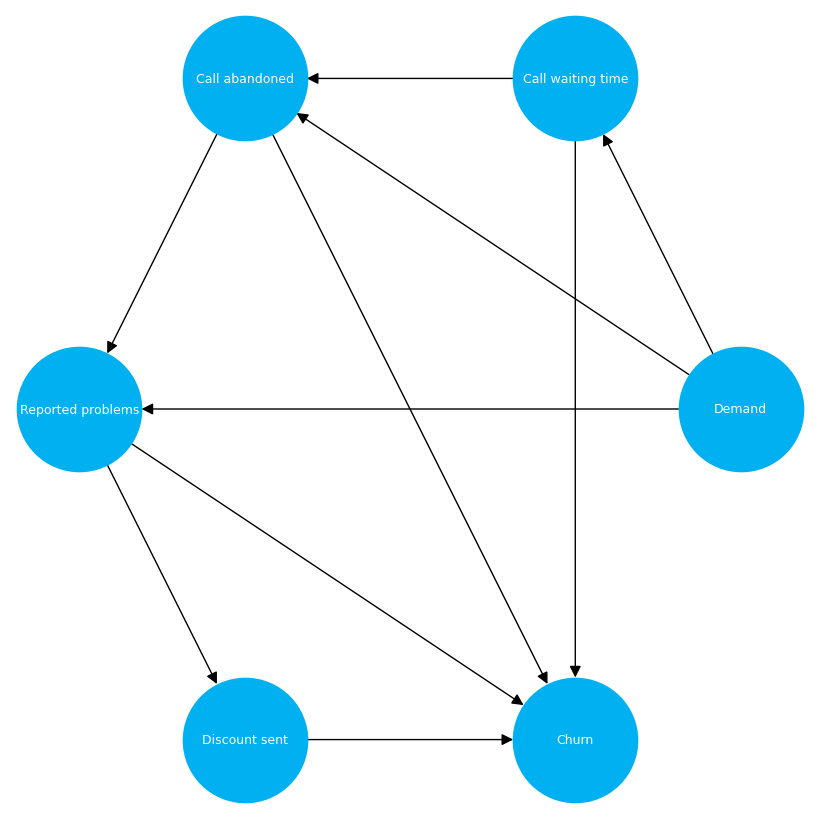

In [5]:
plot_graph(input_graph=graph_actual, node_lookup=node_lookup)

# <ins>Data generating process</ins>

Next, we need to generate data for our case study. As we know the causal graph, we can use our knowledge of the data-generating process to generate some samples.

In [1]:
def data_generator(max_call_waiting, inbound_calls, call_reduction):
    '''
     A data generating function that has the flexibility to reduce the value of node 0 (Call waiting time) - this enables us to calculate ground truth counterfactuals

    Args:
        max_call_waiting (int): Maximum call waiting time in seconds
        inbound_calls (int): Total number of inbound calls (observations in data)
        call_reduction (float): Reduction to apply to call waiting time

    Returns:
        DataFrame: Generated data
    '''
    
    df = pd.DataFrame(columns=node_lookup.values())

    df[node_lookup[0]] = np.random.randint(low=10, high=max_call_waiting, size=(inbound_calls)) # Demand
    df[node_lookup[1]] = (df[node_lookup[0]] * 0.5) * (call_reduction) + np.random.normal(loc=0, scale=40, size=inbound_calls) # Call waiting time
    df[node_lookup[2]] = (df[node_lookup[1]] * 0.5) + (df[node_lookup[0]] * 0.2) + np.random.normal(loc=0, scale=30, size=inbound_calls) # Call abandoned
    df[node_lookup[3]] = (df[node_lookup[2]] * 0.6) + (df[node_lookup[0]] * 0.3) + np.random.normal(loc=0, scale=20, size=inbound_calls) # Reported problems
    df[node_lookup[4]] = (df[node_lookup[3]] * 0.7) + np.random.normal(loc=0, scale=10, size=inbound_calls) # Discount sent
    df[node_lookup[5]] = (0.10 * df[node_lookup[1]] ) + (0.30 * df[node_lookup[2]]) + (0.15 * df[node_lookup[3]]) + (-0.20 * df[node_lookup[4]]) # Churn

    return df

In [7]:
# Generate data
np.random.seed(999)
df = data_generator(max_call_waiting=600, inbound_calls=10000, call_reduction=1.00)
df

,Demand,Call waiting time,Call abandoned,Reported problems,Discount sent,Churn
0,458,215.564320,184.203737,270.827027,180.738762,81.293855
1,358,231.684552,206.417015,246.048185,168.878231,88.225141
2,491,240.964451,179.425270,232.651769,153.540137,82.113764
3,235,142.553731,148.626154,175.441389,138.295402,57.500347
4,485,256.927178,281.410095,326.223968,231.282762,112.792789
...,...,...,...,...,...,...
9995,376,178.442600,214.846263,219.720565,153.335835,84.589057
9996,25,-9.596745,-60.570855,-18.278805,-0.669854,-21.738781
9997,420,255.145635,261.184659,291.118868,191.667868,109.204218
9998,292,217.439395,139.453178,154.491528,98.476326,67.058357


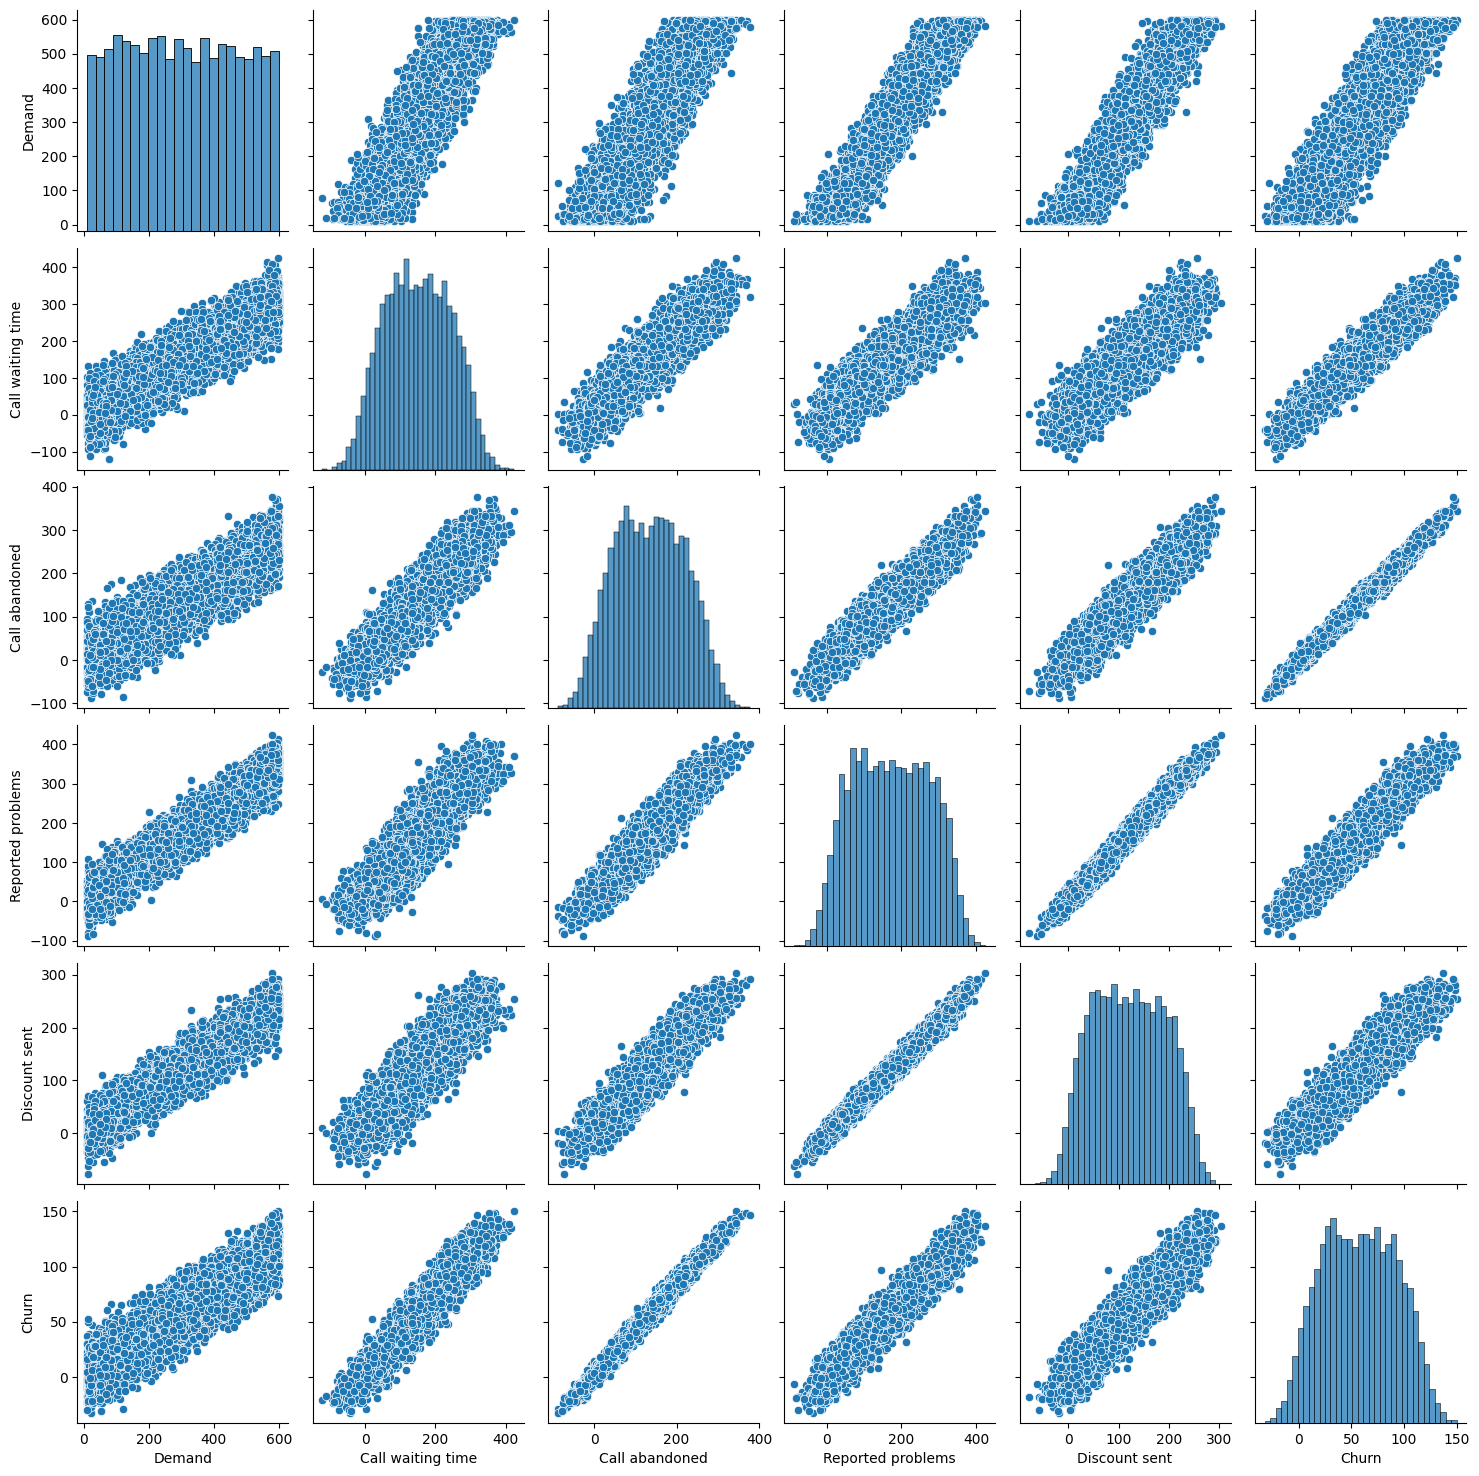

In [8]:
sns.pairplot(df)

# <ins>Training the SCM</ins>

We now have an adjacency matrix which represents our causal graph and some data. We use the gcm module from the dowhy Python package to train an SCM.

It's important to think about what causal mechanism to use for the root and non-root nodes. If you look at our data generator function, you will see all of the relationships are linear. Therefore choosing ridge regression should be sufficient.

In [9]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)

# Create SCM
causal_model = gcm.InvertibleStructuralCausalModel(graph)
causal_model.set_causal_mechanism('Demand', gcm.EmpiricalDistribution()) # Root node
causal_model.set_causal_mechanism('Call waiting time', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Root node
causal_model.set_causal_mechanism('Call abandoned', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root node
causal_model.set_causal_mechanism('Reported problems', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root node
causal_model.set_causal_mechanism('Discount sent', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root 
causal_model.set_causal_mechanism('Churn', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root 
gcm.fit(causal_model, df)

Fitting causal mechanism of node Churn: 100%|██████████| 6/6 [00:00<00:00, 104.36it/s]   


Test permutations of given graph: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


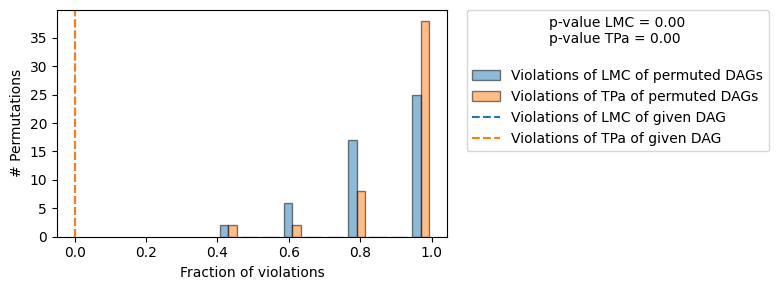

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [10]:
# Check model fit statistics
print(gcm.evaluate_causal_model(causal_model, df))

# <ins>Ridge regression comparion</ins>

We also use ridge regression to help create a baseline comparison. We can look back at the data generator and see that it correctly estimates the coefficients for each variable. However, in addition to directly influencing churn, call waiting time indirectly influences churn through abandoned calls, reported problems and discounts sent. 

When it comes to estimating counterfactuals it is going to be interesting to see how the SCM compares to ridge regression.

In [11]:
# Ridge regression
y = df['Churn'].copy()
X = df.iloc[:, 1:-1].copy()
model = RidgeCV()
model = model.fit(X, y)
y_pred = model.predict(X)

print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_}')
# Ground truth[0.10 0.30 0.15 -0.20]

Intercept: -0.00011863874157569398
Coefficient: [ 0.10000026  0.30000016  0.1500002  -0.19999981]


# <ins>Estimating ground truth</ins>

Before we move on to calculating counterfactuals using causal graphs and ridge regression, we need a ground truth benchmark. We can use our data generator to create counterfactual samples after we have reduced call waiting time by 20%.

We couldn't do this with real-world problems but this method allows us to assess how effective the causal graph and ridge regression is.

In [12]:
# Set call reduction to 20%
reduce = 0.20
call_reduction = 1 - reduce

In [13]:
# Generate counterfactual data
np.random.seed(999)
df_cf = data_generator(max_call_waiting=600, inbound_calls=10000, call_reduction=call_reduction)
df_cf

,Demand,Call waiting time,Call abandoned,Reported problems,Discount sent,Churn
0,458,169.764320,161.303737,257.087027,171.120762,69.706455
1,358,195.884552,188.517015,235.308185,161.360231,79.167741
2,491,191.864451,154.875270,217.921769,143.229137,69.691464
3,235,119.053731,136.876154,168.391389,133.360402,51.554847
4,485,208.427178,257.160095,311.673968,221.097762,100.522289
...,...,...,...,...,...,...
9995,376,140.842600,196.046263,208.440565,145.439835,75.076257
9996,25,-12.096745,-61.820855,-19.028805,-1.194854,-22.371281
9997,420,213.145635,240.184659,278.518868,182.847868,98.578218
9998,292,188.239395,124.853178,145.731528,92.344326,59.670757


# <ins>Estimating counterfactuals</ins>

We can now estimate what would have happened if we had of decreased the call waiting time by 20% using our 3 methods:
- Ground truth (from the data generator)
- Ridge regression
- Causal graph

We see that ridge regression underestimates the impact on churn significantly whilst the causal graph is very close to the ground truth.

In [14]:
# Ground truth counterfactual
ground_truth = round((df['Churn'].sum() - df_cf['Churn'].sum()) / df['Churn'].sum(), 2)

# Causal graph counterfactual
df_counterfactual = gcm.counterfactual_samples(causal_model, {'Call waiting time': lambda x: x*call_reduction}, observed_data=df)
causal_graph = round((df['Churn'].sum() - df_counterfactual['Churn'].sum()) / (df['Churn'].sum()), 3)

# Ridge regression counterfactual
ridge_regression = round((df['Call waiting time'].sum() * 1.0 * model.coef_[0] - (df['Call waiting time'].sum() * call_reduction * model.coef_[0])) / (df['Churn'].sum()), 3)

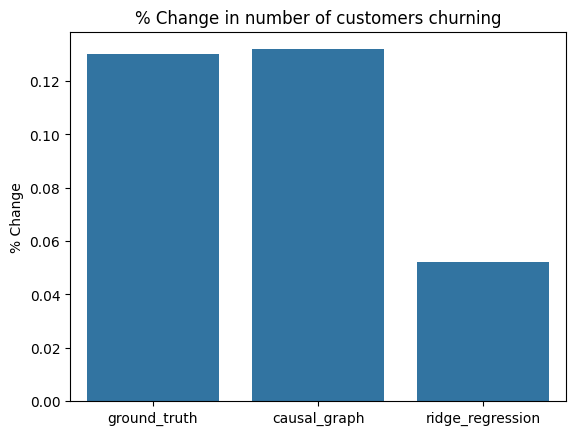

In [15]:
# Plot comparison of results
categories = ['ground_truth', 'causal_graph', 'ridge_regression']
sns.barplot(x=categories, y=[ground_truth, causal_graph, ridge_regression])
plt.ylabel('% Change')
plt.title('% Change in number of customers churning')
plt.show()

# <ins>Future considerations</ins>

This was a simple example to start you thinking about the power of causal graphs.

For more complex situations, several challenges that would need some consideration:
- What about if we don't have the expert domain knowledge to identify the causal graph?
- What if there are non-linear relationships?
- How damaging is multi-collinearity?
- What if some variables have lagged effects?
- How can we deal with high-dimensional datasets (lots of variables)?

All of these points will be covered in future blogs.